In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
from stimuli import staircase

In [9]:
def phi_j_t(X, j, t, t_val, tau_val):
    '''
    evoked potential for neuron j at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[j, :tt + 1])
    return phi

def phi_t(X, t, t_val, tau_val):
    '''
    summed evoked potentials across all neurons at time t
    '''
    cumulative_time_array = np.arange(0, t + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), data[:, :t + 1].transpose())
    return phi


def eta_i_t(X, i, t, t_val, tau_val, eta_0):
    '''
    adaptation potential of neuron i at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[i, :tt + 1])
    return -eta_0 * phi


def rho_i_t(u, i, t, v, delta_u):
    '''
    firint rate of neuron i at time t
    '''
    return rho_0 * np.exp(u[i, t] - v / delta_u)


def log_likelihood(X, u):
    '''
    compute log likelihood of current model
    '''
    likelihoods = []
    for ii in range(num_neurons):
        
        for tt in range(num_timebins):
            
            curr_rho = rho_i_t(u=potentials, v=v, delta_u=delta_u, i=ii, t=tt)
            curr_x = X[ii, tt]
            
            curr_likelihood = np.log(curr_rho) * curr_x - curr_rho
            likelihoods.append(curr_likelihood)
            
    return np.sum(likelihoods)



In [10]:
num_neurons = 15
num_timebins = 300
num_iter = 100
print_iter = 10

tau = 0.01
eta_0 = 0.1
tau_adapt = 0.01
rho_0 = 1
v = 0
delta_u = 1
mu_M = 1e-5
mu_Q = 0.00001
tau_G = 0.01
tau_baseline = 0.1
dt = 0.001

## Generate synthetic data
data = np.random.binomial(n = 1, p = 0.1, size = [num_neurons, num_timebins])
true_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons]) # not used currently, but one could do a simulation to see if the true weights are recovered
learned_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons])

## Initialize arrays
potentials = np.zeros((num_neurons, num_timebins))



In [18]:
## Generate synthetic spike counts


# ## From weight matrix
# for tt in range(num_timebins):
#     for ii in range(num_neurons):
        
#         potential_list = []
#         for jj in range(num_neurons):
#             curr_cumulative_time_array = np.arange(0, tt + 1) # should this be tt + 1?
#             first_term = true_weights[ii, jj] * np.dot(np.exp(-(tt - curr_cumulative_time_array) / tau), data[jj, :tt + 1])
#             second_term = -eta_0 * np.dot(np.exp(-(tt - curr_cumulative_time_array) / tau_adapt), data[jj, :tt + 1])
#             curr_pot = first_term + second_term
#             potential_list.append(curr_pot)

#         potentials[ii, tt] = np.sum(potential_list)
        
# data = np.random.poisson(lam=np.exp(potentials - v / delta_u))



## staircase


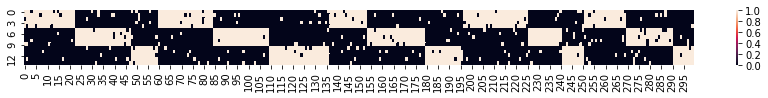

In [25]:
data = staircase(num_neurons=num_neurons, num_timebins=num_timebins)

fig, ax = plt.subplots(figsize=(15,1))  
sns.heatmap(data)

In [311]:
likelihood_trace = []
for iter_num in range(num_iter):
    
    ## Update membrane potential
    for ii in range(num_neurons):
        
        # loop over time bins
        for tt in range(num_timebins):
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            cumulative_time_array = np.arange(0, tt + 1) / 1000.
            phi_unscaled = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
            phi = np.dot(learned_weights[ii, :], phi_unscaled)
            
            eta = eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
            potentials[ii, tt] = phi + eta
            
    
    ## Update weights
    for ii in range(num_neurons):
        for jj in range(num_neurons):
        
            ## loop over time bins
            timebin_summands = []
            for tt in range(num_timebins):
                
                tt_val = tt / 1000.
                
                curr_phi_j_t = phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
                                
                x_minus_rho = data[ii, tt] - rho_i_t(u=potentials, v=v, t=tt, i=ii, delta_u=delta_u)
        
                summand = curr_phi_j_t * x_minus_rho
                timebin_summands.append(summand)
                
            weight_gradient = np.sum(timebin_summands)
            learned_weights[ii, jj] += mu_M * weight_gradient
     
    # print and save likelihoods over time
    if iter_num % print_iter == 0:
        curr_likelihood = log_likelihood(u=potentials, X=data)
        likelihood_trace.append(curr_likelihood)
        print curr_likelihood

-12410.180114856368
-3743.9807591281356
-3143.6119477500397
-2790.443331623677
-2656.902592970455
-2618.385237815084
-2596.2692933553617
-2582.420637736167
-2573.218061825447
-2566.7097211985665


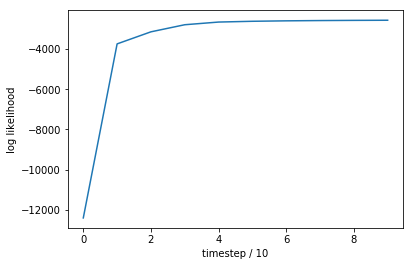

In [321]:
plt.plot(likelihood_trace)
plt.xlabel("timestep / {}".format(print_iter))
plt.ylabel("log likelihood")
plt.show()

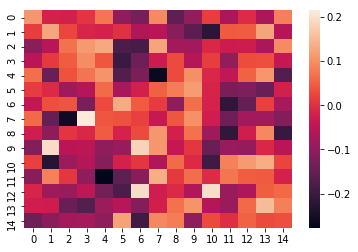

In [313]:
sns.heatmap(learned_weights)

In [322]:
## Generate data from learned weights

simulated_potentials = np.zeros((num_neurons, num_timebins))
    
## Simulate membrane potential
for ii in range(num_neurons):

    # loop over time bins
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        ## loop over neurons
        potential_list = []
        for jj in range(num_neurons):

            curr_weight = learned_weights[ii, jj] * phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
            potential_list.append(curr_weight)

        simulated_potentials[ii, tt] = np.sum(potential_list) + eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)

In [323]:
poisson_rates = np.zeros((num_neurons, num_timebins))
for ii in range(num_neurons):
    for tt in range(num_timebins):
        poisson_rates[ii, tt] = rho_i_t(delta_u=delta_u, i=ii, t=tt, u=simulated_potentials, v=v)


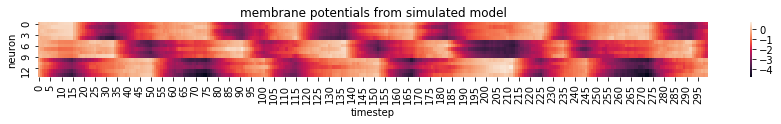

In [327]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(simulated_potentials)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("membrane potentials from simulated model")
plt.show()

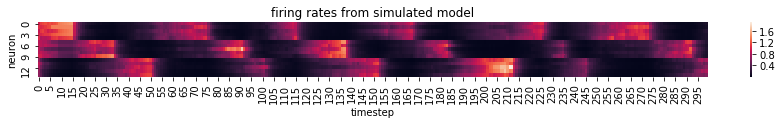

In [328]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(poisson_rates)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("firing rates from simulated model")
plt.show()

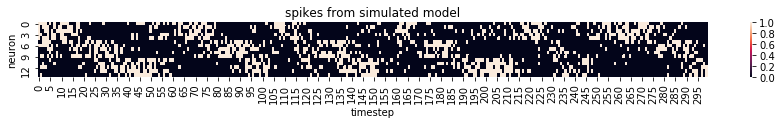

In [329]:
simulated_spikes = np.random.poisson(lam=poisson_rates)
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap((simulated_spikes >= 1).astype(int))
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("spikes from simulated model")
plt.show()
plt.show()

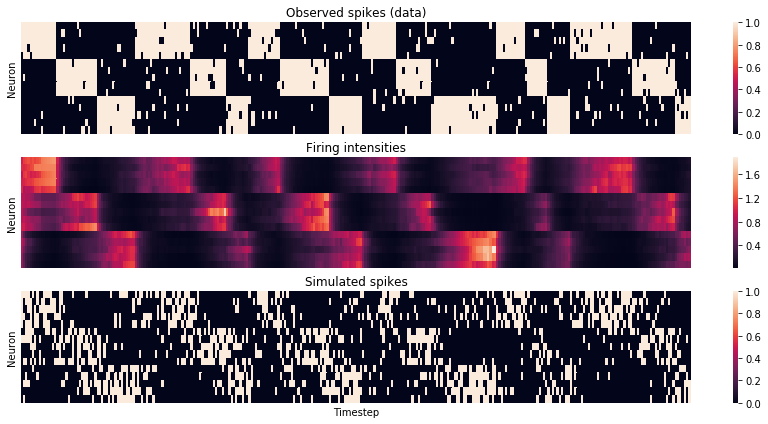

In [332]:
fig, ax = plt.subplots(figsize=(15,7))
plt.subplot(3, 1, 1)
sns.heatmap(data, xticklabels=False, yticklabels=False)
plt.title("Observed spikes (data)")
plt.ylabel("Neuron")
plt.subplot(3, 1, 2)
sns.heatmap(poisson_rates, xticklabels=False, yticklabels=False)
plt.title("Firing intensities")
plt.ylabel("Neuron")
plt.subplot(3, 1, 3)
sns.heatmap((simulated_spikes >= 1).astype(int), xticklabels=False, yticklabels=False)
plt.title("Simulated spikes")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.savefig("/Users/andrewjones/Documents/pillow_lab/variational_spiking_networks/plots/simulated_model_visible_only.png")
plt.show()

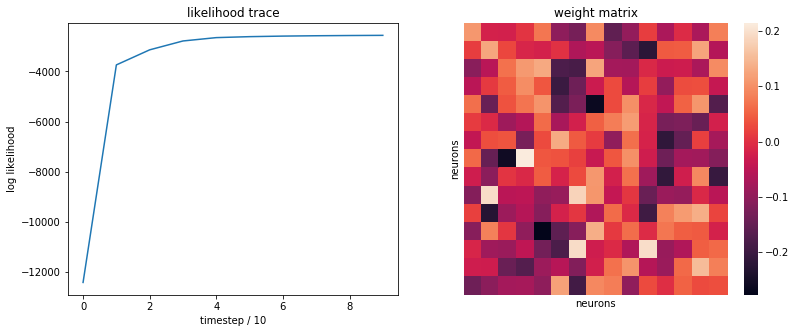

In [340]:
fig, ax = plt.subplots(figsize=(13, 5))
plt.subplot(1, 2, 1)

plt.plot(likelihood_trace)
plt.xlabel("timestep / {}".format(print_iter))
plt.ylabel("log likelihood")
plt.title("likelihood trace")

plt.subplot(1, 2, 2)

sns.heatmap(learned_weights, xticklabels=False, yticklabels=False)
plt.xlabel("neurons")
plt.ylabel("neurons")
plt.title("weight matrix")

plt.savefig("/Users/andrewjones/Documents/pillow_lab/variational_spiking_networks/plots/trained_model_weights_and_likelihood_visible_only.png")
plt.show()